In [1]:
!pip install rasterstats

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
import rioxarray as rxr
import rasterio
import adlfs
import contextily as ctx

In [3]:
gf = gpd.read_file('https://github.com/scottyhq/snotel/raw/main/snotel-sites.geojson')

In [4]:
snotel_gf = gf[(gf.isActive==True) & (gf.timeseries==True)]
snotel_gf = snotel_gf[(snotel_gf.beginDate<'2015-01-01') & (snotel_gf.endDate>'2022-01-01')]
snotel_gf = snotel_gf[snotel_gf.state!='Alaska']

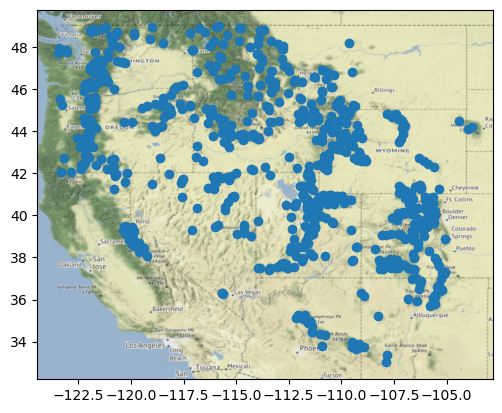

In [5]:
f,ax=plt.subplots()
snotel_gf.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=snotel_gf.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [6]:
for i,row in snotel_gf.iterrows():
    snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{row.code}.parquet').loc[slice('2015-01-01','2022-12-31')]
    dates = snotel_data.groupby(snotel_data.index.year).idxmax()['WTEQ']
    #print(dates)
    if len(dates)==8:
        snotel_gf.loc[i,['max_swe_2015','max_swe_2016','max_swe_2017','max_swe_2018','max_swe_2019','max_swe_2020','max_swe_2021','max_swe_2022']] = dates.values
    #date_index = []
    #for date in dates.index.values:
    #    date_index.append(f'max_swe_{date}')
    #snotel_gf = snotel_gf.loc[i,iter(date_index)] = dates.loc[2015:2022]

In [7]:
snotel_gf

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,timeseries,geometry,max_swe_2015,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022
0,301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,True,...,True,POINT (-120.79192 41.23583),2015-12-28T00:00:00.000000000,2016-02-20T00:00:00.000000000,2017-03-09T00:00:00.000000000,2018-03-27T00:00:00.000000000,2019-03-16T00:00:00.000000000,2020-02-01T00:00:00.000000000,2021-03-15T00:00:00.000000000,2022-03-17T00:00:00.000000000
1,907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,True,...,True,POINT (-112.27118 37.52217),2015-03-05T00:00:00.000000000,2016-02-02T00:00:00.000000000,2017-03-06T00:00:00.000000000,2018-03-19T00:00:00.000000000,2019-03-22T00:00:00.000000000,2020-03-28T00:00:00.000000000,2021-03-17T00:00:00.000000000,2022-03-12T00:00:00.000000000
2,916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,True,...,True,POINT (-111.95902 45.59723),2015-04-17T00:00:00.000000000,2016-04-06T00:00:00.000000000,2017-05-02T00:00:00.000000000,2018-04-17T00:00:00.000000000,2019-05-01T00:00:00.000000000,2020-04-23T00:00:00.000000000,2021-04-27T00:00:00.000000000,2022-06-03T00:00:00.000000000
4,908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,True,...,True,POINT (-121.69847 47.77957),2015-12-28T00:00:00.000000000,2016-04-05T00:00:00.000000000,2017-04-19T00:00:00.000000000,2018-04-18T00:00:00.000000000,2019-03-24T00:00:00.000000000,2020-04-11T00:00:00.000000000,2021-04-17T00:00:00.000000000,2022-04-26T00:00:00.000000000
8,302_OR_SNTL,Aneroid Lake #2,2255.520020,45.213280,-117.192581,Wallowa,Oregon,1980-10-01 00:00:00,2100-01-01,True,...,True,POINT (-117.19258 45.21328),2015-04-09T00:00:00.000000000,2016-05-01T00:00:00.000000000,2017-05-03T00:00:00.000000000,2018-04-22T00:00:00.000000000,2019-04-22T00:00:00.000000000,2020-04-26T00:00:00.000000000,2021-04-16T00:00:00.000000000,2022-05-15T00:00:00.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,True,...,True,POINT (-110.91773 33.81242),2015-01-18T00:00:00.000000000,2016-02-09T00:00:00.000000000,2017-01-25T00:00:00.000000000,2018-02-20T00:00:00.000000000,2019-02-23T00:00:00.000000000,2020-01-01T00:00:00.000000000,2021-01-30T00:00:00.000000000,2022-01-02T00:00:00.000000000
926,1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,True,...,True,POINT (-111.35685 39.13233),2015-03-04T00:00:00.000000000,2016-03-29T00:00:00.000000000,2017-03-07T00:00:00.000000000,2018-03-23T00:00:00.000000000,2019-03-30T00:00:00.000000000,2020-03-30T00:00:00.000000000,2021-03-24T00:00:00.000000000,2022-03-17T00:00:00.000000000
927,1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,True,...,True,POINT (-112.77495 37.74797),2015-03-04T00:00:00.000000000,2016-03-31T00:00:00.000000000,2017-04-04T00:00:00.000000000,2018-03-05T00:00:00.000000000,2019-03-22T00:00:00.000000000,2020-03-28T00:00:00.000000000,2021-03-27T00:00:00.000000000,2022-03-21T00:00:00.000000000
928,878_WY_SNTL,Younts Peak,2545.080078,43.932251,-109.817749,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,True,...,True,POINT (-109.81775 43.93225),2015-12-24T00:00:00.000000000,2016-03-29T00:00:00.000000000,2017-03-17T00:00:00.000000000,2018-04-15T00:00:00.000000000,2019-04-16T00:00:00.000000000,2020-04-17T00:00:00.000000000,2021-04-02T00:00:00.000000000,2022-04-29T00:00:00.000000000


In [8]:
snotel_gf = snotel_gf.to_crs('EPSG:32611')

In [9]:
buffer = 1000
snotel_gf = gpd.GeoDataFrame(snotel_gf,geometry=snotel_gf.buffer(buffer))

In [10]:
years = [2015,2016,2017,2018,2019,2020,2021,2022]
stats=['count', 'min', 'max', 'mean', 'median', 'std']

In [11]:
sas_token = "se=2023-02-13T19%3A15Z&sp=racwdl&sv=2018-11-09&sr=c&skoid=b4d39ccb-ca9c-4e9d-a183-5e0f3ba3e609&sktid=f6b6dd5b-f02f-441a-99a0-162ac5060bd2&skt=2023-02-06T19%3A16%3A18Z&ske=2023-02-13T19%3A15%3A00Z&sks=b&skv=2018-11-09&sig=z/AIiFdLunJ/tg9i/gJUqvLRgRxghWgXiIyAm1sV2Zo%3D"
tile_names = [tile[-5:] for tile in adlfs.AzureBlobFileSystem(account_name="snowmelt", credential=sas_token, anon=False).ls('snowmelt/eric/MGRS/')]

In [12]:
for i,row in snotel_gf.iterrows():
    if row.mgrs in tile_names:
        print(f'{row.code} in MGRS square {row.mgrs}')
        #f,ax=plt.subplots()
        #aoi = rxr.open_rasterio(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_allyears_median_40m.tif")
        #aoi.plot(ax=ax)
        
        
        # only keep this line temporary, need to get crs from it. otherwise for plotting purposes, should use aoi from all years
        aoi = rxr.open_rasterio(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_2015_median_40m.tif")
        
        
        snotel_row_proj = snotel_gf[snotel_gf.index==i].to_crs(aoi.rio.crs)
        #snotel_row_proj.boundary.plot(ax=ax,color='red')
        #ax.set_xlim([snotel_row_proj.total_bounds[0]-2000,snotel_row_proj.total_bounds[2]+2000])
        #ax.set_ylim([snotel_row_proj.total_bounds[1]-2000,snotel_row_proj.total_bounds[3]+2000])
        
        
    
        for year in years:
            #raster = rxr.open_rasterio(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_{year}_median_40m.tif")
            try:
                raster = rasterio.open(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_{year}_median_40m.tif")
                statistics = rasterstats.zonal_stats(snotel_row_proj, raster.read(1), affine=raster.transform, stats=stats, nodata=np.nan)
                snotel_gf.loc[i,f'sar_runoff_{year}'] = statistics[0]['median']
            except:
                print(f'Error with tile {row.mgrs} for year {year}')

301_CA_SNTL in MGRS square 10TFL
908_WA_SNTL in MGRS square 10TET
1000_OR_SNTL in MGRS square 10TEN
1166_OR_SNTL in MGRS square 10TEQ
341_OR_SNTL in MGRS square 10TEM
343_OR_SNTL in MGRS square 10TDM
344_OR_SNTL in MGRS square 10TEM
351_OR_SNTL in MGRS square 10TER
352_WA_SNTL in MGRS square 10TFT
1107_WA_SNTL in MGRS square 10TDT
375_WA_SNTL in MGRS square 10TFS
942_WA_SNTL in MGRS square 10TET
1109_WA_SNTL in MGRS square 10TER
388_OR_SNTL in MGRS square 10TEP
389_WY_SNTL in MGRS square 13TCH
1085_WA_SNTL in MGRS square 10TFS
391_CA_SNTL in MGRS square 10TGM
395_OR_SNTL in MGRS square 10TEN
398_OR_SNTL in MGRS square 10TEQ
401_OR_SNTL in MGRS square 10TFR
406_OR_SNTL in MGRS square 10TEN
418_WA_SNTL in MGRS square 10TFT
420_WA_SNTL in MGRS square 10TFT
1010_OR_SNTL in MGRS square 10TFN
977_CA_SNTL in MGRS square 10TFM
434_OR_SNTL in MGRS square 10TEQ
442_OR_SNTL in MGRS square 10TEN
446_CA_SNTL in MGRS square 10TGM
478_WA_SNTL in MGRS square 10TFT
479_OR_SNTL in MGRS square 10TEM
483_

In [13]:
for year in years:
    snotel_gf[f'offset_{year}'] = pd.to_datetime(snotel_gf[f'max_swe_{year}']).dt.dayofyear - snotel_gf[f'sar_runoff_{year}']

In [14]:
snotel_gf['median_offset'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('offset')]].abs().median(axis=1)
snotel_gf['mean_offset'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('offset')]].abs().mean(axis=1)

In [15]:
snotel_gf.sort_values('median_offset').head(20)

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,offset_2015,offset_2016,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset
333,502_WA_SNTL,Green Lake,1804.416016,46.547409,-121.170929,Yakima,Washington,1981-10-01,2100-01-01,True,...,274.0,18.0,18.0,2.0,-9.0,-11.0,0.0,-5.0,10.00,42.1250
555,642_WA_SNTL,Morse Lake,1648.968018,46.905849,-121.482697,Yakima,Washington,1978-10-01,2100-01-01,True,...,271.0,-7.0,6.0,-1.0,-13.0,-21.0,-34.0,9.0,11.00,45.2500
219,446_CA_SNTL,Dismal Swamp,2243.327881,41.991268,-120.180328,Modoc,California,1979-10-01,2100-01-01,True,...,267.0,-11.0,6.0,2.0,-12.0,-9.0,-24.0,18.0,11.50,43.6250
697,729_OR_SNTL,Salt Creek Falls,1286.255981,43.611931,-122.117577,Lane,Oregon,1979-10-01,2100-01-01,True,...,262.0,-8.5,-15.0,-16.0,-19.0,5.0,-0.5,7.5,11.75,41.6875
782,788_WA_SNTL,Stampede Pass,1173.479980,47.274269,-121.341621,King,Washington,1979-10-01,2100-01-01,True,...,274.0,13.0,-12.0,2.0,-23.0,13.0,25.0,1.0,13.00,45.3750
112,1107_WA_SNTL,Buckinghorse,1484.375977,47.708599,-123.457474,Jefferson,Washington,2008-06-19,2100-01-01,True,...,110.0,-14.0,9.0,11.0,5.0,-12.0,-29.0,-25.0,13.00,26.8750
144,1085_WA_SNTL,Cayuse Pass,1597.151978,46.869541,-121.534302,Pierce,Washington,2006-10-01,2100-01-01,True,...,274.0,17.0,6.0,7.0,-11.0,-21.0,-7.0,15.0,13.00,44.7500
578,655_OR_SNTL,Mud Ridge,1240.536011,45.253620,-121.736732,Clackamas,Oregon,1978-10-01,2100-01-01,True,...,273.0,15.0,13.0,15.0,-1.0,21.0,-4.0,10.0,14.00,44.0000
185,418_WA_SNTL,Corral Pass,1767.839966,47.018719,-121.464638,Pierce,Washington,1979-10-01,2100-01-01,True,...,17.0,-9.0,-62.0,199.0,-7.0,-13.0,-15.0,13.0,14.00,41.8750
371,529_OR_SNTL,Holland Meadows,1502.663940,43.669170,-122.568771,Lane,Oregon,1979-10-01,2100-01-01,True,...,277.0,-64.5,2.0,-0.5,-14.0,15.0,9.0,-89.0,14.50,58.8750


Text(0.5, 0, 'Offset [Days]')

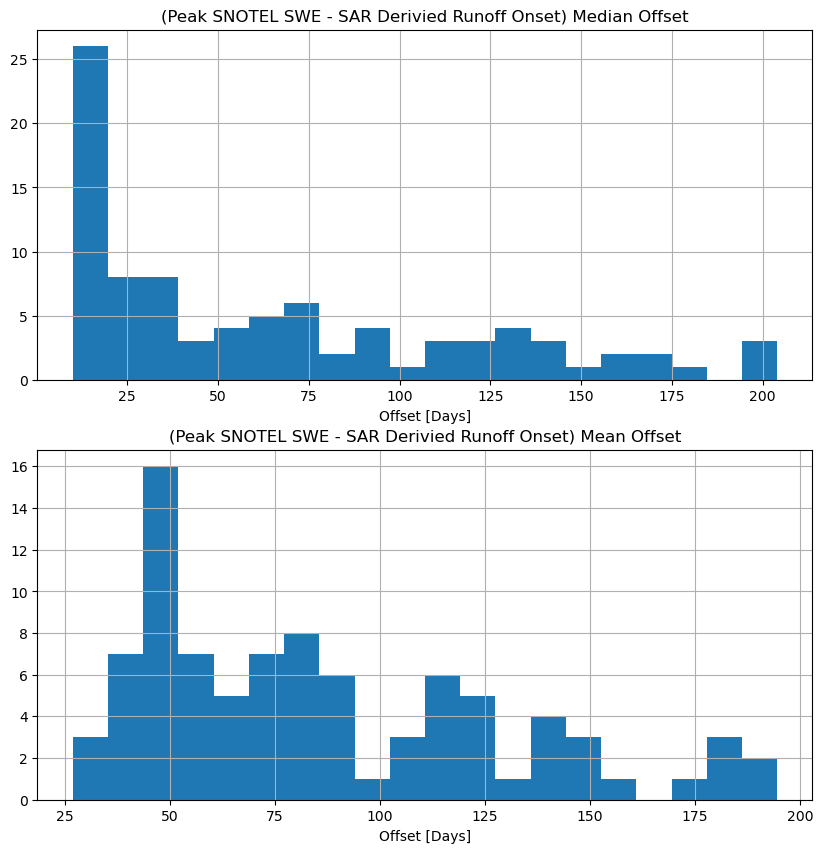

In [16]:
f,ax=plt.subplots(2,1,figsize=(10,10))
snotel_gf['median_offset'].hist(bins=20,ax=ax[0])
snotel_gf['mean_offset'].hist(bins=20,ax=ax[1])
ax[0].set_title('(Peak SNOTEL SWE - SAR Derivied Runoff Onset) Median Offset')
ax[1].set_title('(Peak SNOTEL SWE - SAR Derivied Runoff Onset) Mean Offset')
ax[0].set_xlabel('Offset [Days]')
ax[1].set_xlabel('Offset [Days]')

In [17]:
snotel_gf['median_offset'].median()

46.25

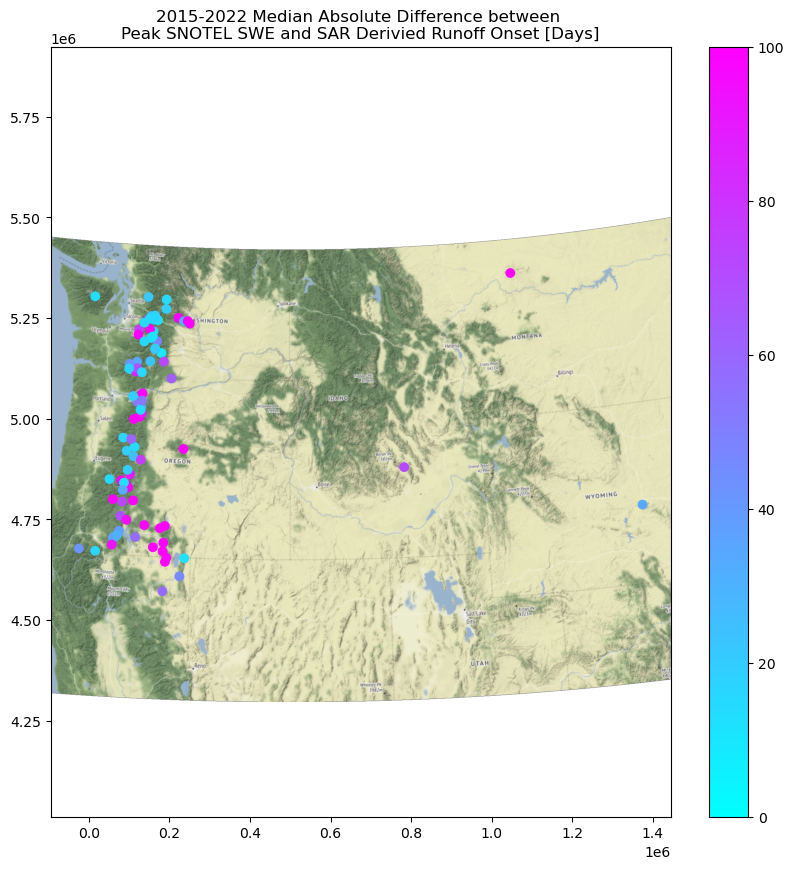

In [18]:
f,ax=plt.subplots(figsize=(10,10))
snotel_gf_projected = gpd.GeoDataFrame(snotel_gf,geometry=gf.geometry).to_crs('EPSG:32611')
snotel_gf_projected.plot(column='median_offset',ax=ax,legend=True,cmap='cool',vmin=0,vmax=100)
ax.axis('equal')
ax.set_title('2015-2022 Median Absolute Difference between \nPeak SNOTEL SWE and SAR Derivied Runoff Onset [Days]')
ctx.add_basemap(ax=ax, crs=snotel_gf_projected.crs, source=ctx.providers.Stamen.Terrain, attribution=False)